# PokeGAN

Simple GAN trained on all the pokemon sprite images. No transfer learning is used and the only input to the generator is the random vector.

In [35]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(".")))

In [338]:
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from src import utils
from src.gan import generators, discriminators

### Load Dataset

In [319]:
image_root_dir = "../data/images/"
image_data, filenames = utils.load_images(image_root_dir)

Total number of files: 857


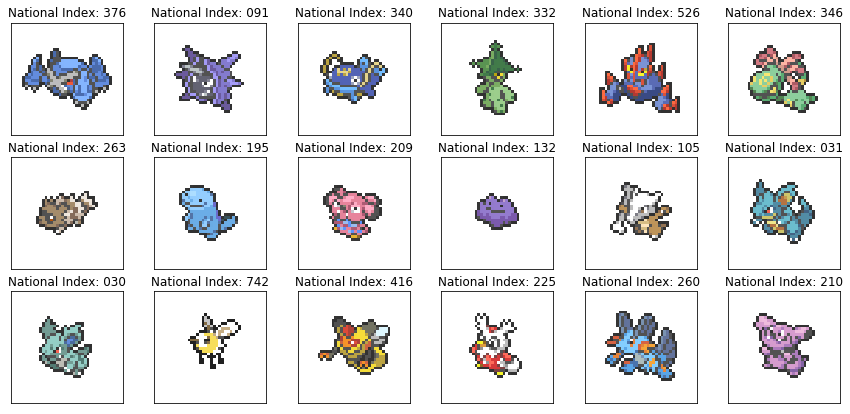

In [320]:
sample = np.random.choice(len(image_data), size=18, replace=False)
fig = plt.figure(figsize=(15, 7))
for i, img_index in enumerate(sample):
    ax = fig.add_subplot(3, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(image_data[img_index])
    ax.set_title(f"National Index: {filenames[img_index][:3]}")

### Datasets & DataLoaders

In [322]:
data = torch.from_numpy(image_data)

In [323]:
data.size(), data.dtype

(torch.Size([857, 40, 40, 3]), torch.float32)

In [345]:
data.shape

torch.Size([857, 40, 40, 3])

In [325]:
training_dataset = torch.utils.data.TensorDataset(data)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True)

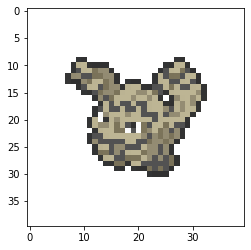

In [326]:
dataset_sample = next(iter(training_dataloader))[0][0]
plt.imshow(dataset_sample)

## Networks

In [285]:
img_size = 40

In [378]:
img_size = 40

# Discriminator
d_in = img_size * img_size * 3
d_hidden = [1000, 500]
d_out = 1

# Generator
noise_size = 100
g_hidden = [250, 1000]
g_out = d_in

dropout = 0.2

### Discriminator

In [374]:
D = discriminators.FCDiscriminator(d_in, d_hidden, d_out, dropout=dropout)
D

FCDiscriminator(
  (layers): ModuleList(
    (0): Linear(in_features=4800, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)

### Generator

In [379]:
G = generators.BasicFCGenerator(noise_size, g_hidden, g_out, dropout)
G

BasicFCGenerator(
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=250, bias=True)
    (1): Linear(in_features=250, out_features=1000, bias=True)
  )
  (out): Linear(in_features=1000, out_features=4800, bias=True)
  (dropout): Dropout(p=0.2)
)

### Losses

In [380]:
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    labels = torch.ones_like(D_out)
    labels = labels * 0.9 if smooth else labels 
    
    loss_criterion = nn.BCEWithLogitsLoss()
    loss = loss_criterion(D_out, labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    labels = torch.zeros_like(D_out)
    
    loss_criterion = nn.BCEWithLogitsLoss()
    loss = loss_criterion(D_out, labels)
    return loss

### Optimisers

In [336]:
# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

## Training

In [ ]:
# training hyperparams
num_epochs = 40

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = utils.generate_random((sample_size, noise_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, real_images in enumerate(training_dataloader):
                
        real_images = real_images[0]
        batch_size = real_images.size(0)
        real_images = real_images * 2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
                
        # 1. Train with real images
        d_optimizer.zero_grad()
        
        # Compute the discriminator losses on real images
        # use smoothed labels
        batch_out_real = D.forward(real_images)
        d_real_loss = real_loss(batch_out_real, smooth=True)
        
        # 2. Train with fake images
        # Generate fake images
        z = utils.generate_random((batch_size, noise_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        
        # add up real and fake losses and perform backprop
        batch_out_fake = D.forward(fake_images)
        d_fake_loss = fake_loss(batch_out_fake)
    
        d_loss = d_fake_loss + d_real_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        
        # 1. Train with fake images and flipped labels
        g_optimizer.zero_grad()
        
        # Generate fake images
        z = utils.generate_random((batch_size, noise_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        
        # perform backprop
        gen_out_fake = D(fake_images)
        g_loss = real_loss(gen_out_fake)
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   40] | d_loss: 1.3638 | g_loss: 0.6696
Epoch [    2/   40] | d_loss: 1.3639 | g_loss: 0.6721
Epoch [    3/   40] | d_loss: 1.3654 | g_loss: 0.6706
Epoch [    4/   40] | d_loss: 1.3647 | g_loss: 0.6703
Epoch [    5/   40] | d_loss: 1.3575 | g_loss: 0.6721
Epoch [    6/   40] | d_loss: 1.3563 | g_loss: 0.6710
Epoch [    7/   40] | d_loss: 1.3710 | g_loss: 0.6677
Epoch [    8/   40] | d_loss: 1.3596 | g_loss: 0.6705
Epoch [    9/   40] | d_loss: 1.3605 | g_loss: 0.6695
Epoch [   10/   40] | d_loss: 1.3557 | g_loss: 0.6702
Epoch [   11/   40] | d_loss: 1.3620 | g_loss: 0.6685
Epoch [   12/   40] | d_loss: 1.3564 | g_loss: 0.6684
Epoch [   13/   40] | d_loss: 1.3532 | g_loss: 0.6713
Epoch [   14/   40] | d_loss: 1.3633 | g_loss: 0.6698
Epoch [   15/   40] | d_loss: 1.3590 | g_loss: 0.6696
Epoch [   16/   40] | d_loss: 1.3554 | g_loss: 0.6670
Epoch [   17/   40] | d_loss: 1.3731 | g_loss: 0.6706
Epoch [   18/   40] | d_loss: 1.3614 | g_loss: 0.6696
Epoch [   19/   40] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

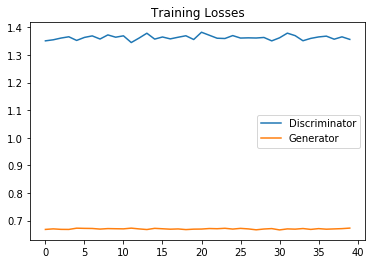

In [382]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Sampling

In [383]:
# randomly generated, new latent vectors
sample_size=16
rand_z = utils.generate_random((sample_size, noise_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
with torch.no_grad():
    rand_images = G(rand_z)

In [360]:
def reshape_sample(samples, img_size, is_rgb=True):
    samples = (samples + 1) / 2  # Reverse scaling
    samples = samples.view(samples.size(0), img_size, img_size, 3 if is_rgb else 1)
    samples.detach()
    return samples.numpy()

In [385]:
reshaped_images = reshape_sample(rand_images, img_size)

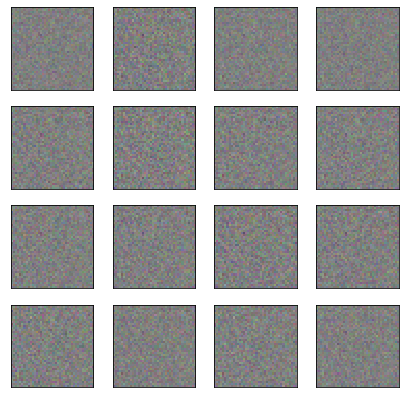

In [386]:
fig = plt.figure(figsize=(7, 7))
for i, s in enumerate(reshaped_images):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(s)